In [72]:
# set root directory path
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get("PROJECT_SRC")
os.chdir(src_path)

src_path

'C:\\Programming\\PyPSA-GB_2030\\PyPSA-GB'

In [73]:
import pypsa
import matplotlib.pyplot as plt

plt.style.use("ggplot")

from tabulate import tabulate
import seaborn as sns
import pandas as pd
import loads
import cartopy.crs as ccrs

import data_reader_writer


# 2030 Demand Using FES
The following are based on the data from the 2022 FES and from the ESPENI dataset to generate some demand curves that will show the demand for electricity in 2030. This demand can be split and shown for each of the main buses in the UK as and is shown for the full 2030 year as well as for one singular data in the year.

In [74]:
# start and end of simulation
start = "2030-01-01 00:00:00"
end = "2030-12-31 23:30:00"

# time step as fraction of hour
time_step = 1.

year_baseline = 2020
FES_year = 2022
FES_scenario = "Leading The Way"

In [75]:
year = int(start[0:4])

loads.write_loads(year)
loads.write_loads_p_set(start, end, year, time_step, "historical", year_baseline=year_baseline, scenario=FES_scenario,
                        FES=FES_year)

df_loads = pd.read_csv("LOPF_data/loads-p_set.csv", index_col=0)

Text(0, 0.5, 'Load [MW]')

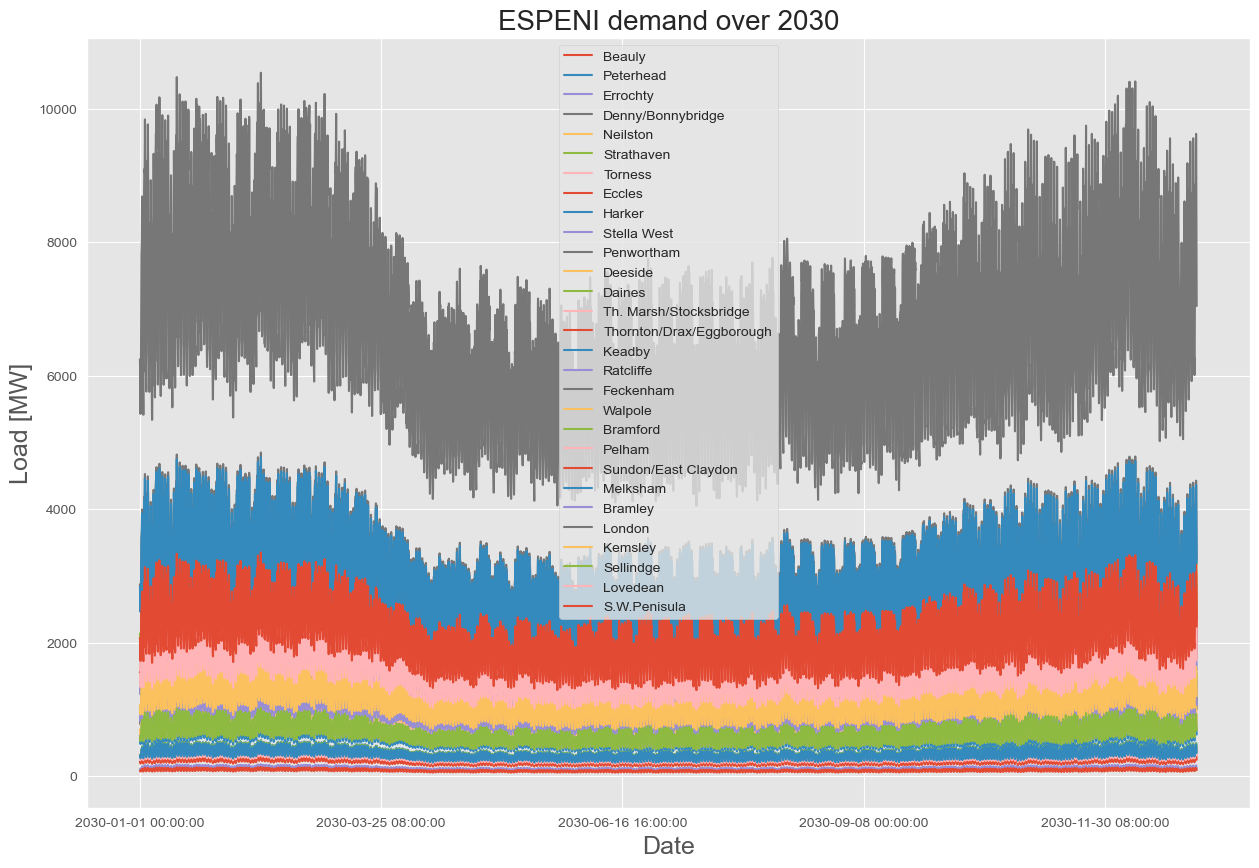

In [76]:
# plot demand for the year sorting by bus
df_loads.plot(linestyle='-', figsize=(15, 10))
plt.title(f"ESPENI demand over {year}", fontsize=20)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Load [MW]", fontsize=18)

Text(0, 0.5, 'Load [MW]')

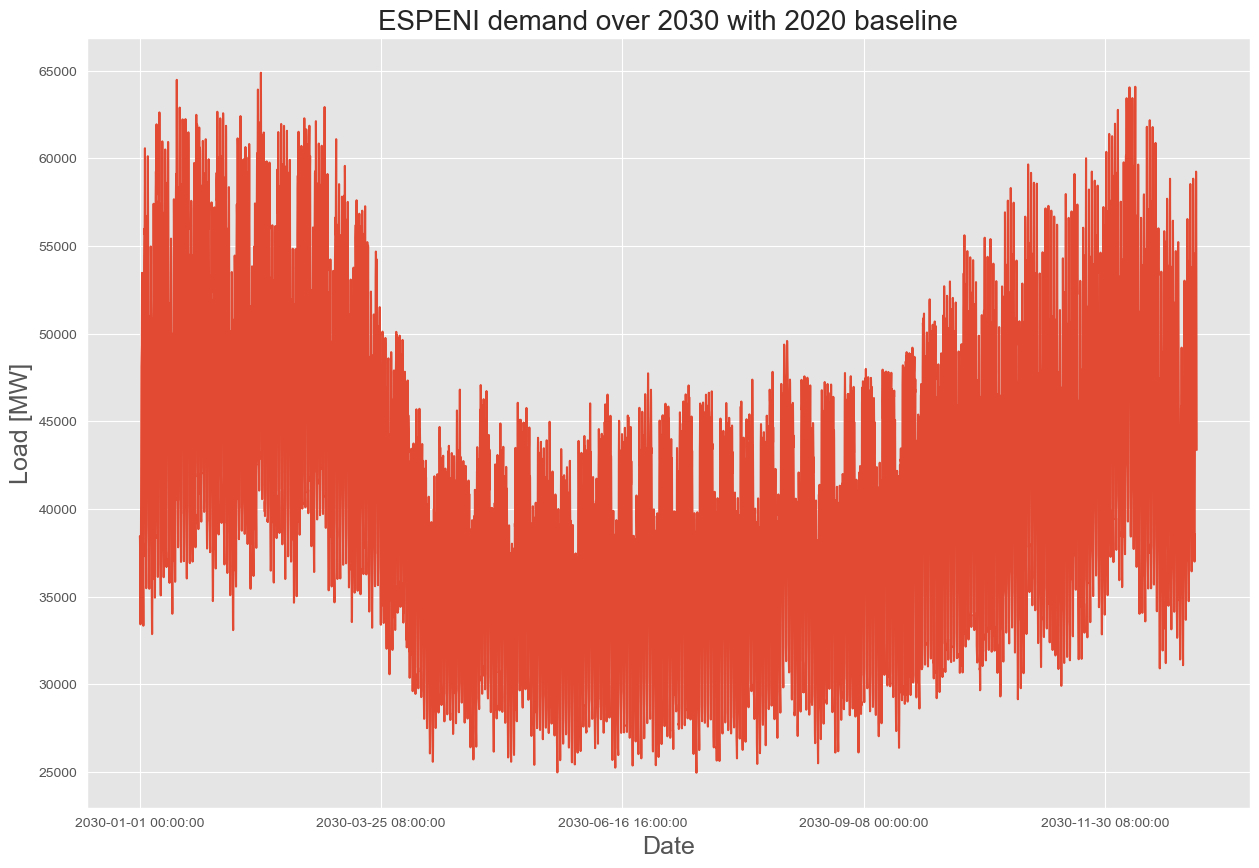

In [77]:
# plot demand for the year
df_loads["Total"] = df_loads.sum(axis=1)
df_loads["Total"].plot(linestyle='-', figsize=(15, 10))
plt.title(f"ESPENI demand over {year} with {year_baseline} baseline", fontsize=20)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Load [MW]", fontsize=18)

# 2030 Generation

In [78]:
plt.rcParams.update({'font.size': 22})

start = '2030-01-01 00:00:00'
end = '2030-06-30 23:30:00'
# year of simulation
year = int(start[0:4])
# time step as fraction of hour
time_step = 1.
year_baseline = 2012

scenarios = ["Leading The Way", ]  # "Consumer Transformation", "System Transformation"]
generation_overall_names = ["ltw", ]  # "ct", "st"]
generation_timestep_names = ["ltw", ]  # "ct", "st"]

In [79]:
for i in range(len(scenarios)):
    data_reader_writer.data_writer(start, end, time_step, year, demand_dataset="eload", year_baseline=year_baseline,
                                   scenario=scenarios[i], FES=FES_year, merge_generators=True, scale_to_peak=True,
                                   networkmodel="Reduced", P2G=True)
    network = pypsa.Network()
    network.import_from_csv_folder("LOPF_data")

    contingency_factor = 4
    network.lines.s_max_pu *= contingency_factor

    network.optimize(solver_name="gurobi", snapshots=network.snapshots)

    p_by_carrier = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()

    storage_by_carrier = network.storage_units_t.p.groupby(network.storage_units.carrier, axis=1).sum()

    # to show on graph set the negative storage values to zero
    storage_by_carrier[storage_by_carrier < 0] = 0

    p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

    imp = network.links_t.p0.copy()
    imp[imp < 0] = 0
    imp["Interconnectors Import"] = imp.sum(axis=1)
    interconnector_import = imp[["Interconnectors Import"]]

    p_by_carrier = pd.concat([p_by_carrier, interconnector_import], axis=1)

    exp = network.links_t.p0.copy()
    exp[exp > 0] = 0
    exp["Interconnectors Export"] = exp.sum(axis=1)
    interconnector_export = exp[["Interconnectors Export"]]

    # group biomass stuff
    p_by_carrier["Biomass"] = (p_by_carrier["Biomass (dedicated)"] + p_by_carrier["Biomass (co-firing)"])

    # rename the hydro bit
    p_by_carrier = p_by_carrier.rename(columns={"Large Hydro": "Hydro"})
    p_by_carrier = p_by_carrier.rename(columns={"Interconnector": "Interconnectors Import"})

    generators_p_nom = network.generators.p_nom.groupby(network.generators.carrier).sum().sort_values()
    if year > 2020:
        generators_p_nom.drop("Unmet Load", inplace=True)
    generators_p_nom.drop(generators_p_nom[generators_p_nom < 50].index, inplace=True)

    plt.rcParams.update({"font.size": 12})
    # bar chart
    plt.figure(figsize=(10, 4))
    plt.bar(generators_p_nom.index, generators_p_nom.values / 1000)
    plt.xticks(generators_p_nom.index, rotation=90)
    plt.ylabel("GW")
    plt.grid(color="grey", linewidth=1, axis="both", alpha=0.5)
    plt.title("Installed capacity in year " + str(year) + " for " + scenarios[i])
    plt.savefig(f"C:/Programming/PyPSA-GB_2030/notebooks/Ramiz/gen_overall_{generation_overall_names[i]}.pdf",
                format="pdf", bbox_inches="tight")
    plt.show()

    ######################################################
    tabular_data = []
    tabular_headers = ["index", "gen"]
    for index, col in generators_p_nom.items():
        tabular_data.append([index, col])
    # print(tabulate(tabular_data=tabular_data, tablefmt="pipe", stralign="center", numalign="center"))
    print(tabular_data)
    ######################################################
    cols = [
        "Nuclear",
        "Biomass",
        "Waste",
        "Oil",
        "Natural Gas",
        "Hydrogen",
        "CCS Gas",
        "CCS Biomass",
        "Pumped Storage Hydroelectric",
        "Hydro",
        "Battery",
        "Compressed Air",
        "Liquid Air",
        "Wind Offshore",
        "Wind Onshore",
        "Solar Photovoltaics",
        "Interconnectors Import",
        "Unmet Load",
    ]

    p_by_carrier = p_by_carrier[cols]

    p_by_carrier.drop((p_by_carrier.max()[p_by_carrier.max() < 50.0]).index, axis=1, inplace=True)

    colors = {
        "Coal": "grey",
        "Diesel/Gas oil": "black",
        "Diesel/gas Diesel/Gas oil": "black",
        "Oil": "black",
        "Unmet Load": "black",
        "Anaerobic Digestion": "green",
        "Waste": "chocolate",
        "Sewage Sludge Digestion": "green",
        "Landfill Gas": "green",
        "Biomass (dedicated)": "green",
        "Biomass (co-firing)": "green",
        "Biomass": "green",
        "CCS Biomass": "darkgreen",
        "Interconnectors Import": "pink",
        "B6 import": "pink",
        "Sour gas": "lightcoral",
        "Natural Gas": "lightcoral",
        "CCS Gas": "lightcoral",
        "Hydrogen": "deeppink",
        "Nuclear": "orange",
        "Shoreline Wave": "aqua",
        "Tidal Barrage and Tidal Stream": "aqua",
        "Hydro": "turquoise",
        "Large Hydro": "turquoise",
        "Small Hydro": "turquoise",
        "Pumped Storage Hydroelectric": "darkturquoise",
        "Battery": "lime",
        "Compressed Air": "greenyellow",
        "Liquid Air": "lawngreen",
        "Wind Offshore": "lightskyblue",
        "Wind Onshore": "deepskyblue",
        "Solar Photovoltaics": "yellow",
    }

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(15, 10)
    (p_by_carrier / 1e3).plot(kind="area", ax=ax, linewidth=0, color=[colors[col] for col in p_by_carrier.columns])

    # # stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
    # (interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
    # # rescale the y axis
    # ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_carrier / 1e3).sum(axis=1).max()])

    # Shrink current axis's height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(loc="upper center", bbox_to_anchor=(0.52, -0.05), fancybox=True, shadow=True, ncol=5)

    ax.set_ylabel("GW")

    ax.set_xlabel("")
    plt.savefig(f"C:/Programming/PyPSA-GB_2030/notebooks/Ramiz/gen_timestep_{generation_timestep_names[i]}.pdf",
                format="pdf", bbox_inches="tight")

C:\Programming\PyPSA-GB_2030\PyPSA-GB\distance_calculator.py:32: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Applications\Anaconda\envs\PyPSA-GB\Lib\encodings\unicode_escape.py:26: DeprecationWarning:

invalid escape sequence '\F'

C:\Applications\Anaconda\envs\PyPSA-GB\Lib\encodings\unicode_escape.py:26: DeprecationWarning:

invalid escape sequence '\F'

C:\Applications\Anaconda\envs\PyPSA-GB\Lib\encodings\unicode_escape.py:26: DeprecationWarning:

invalid escape sequence '\F'

C:\Applications\Anaconda\envs\PyPSA-GB\Lib\encodings\unicode_escape.py:26: DeprecationWarning:

invalid escape sequence '\F'

C:\Applications\Anaconda\envs\PyPSA-GB\Lib\encodings\unicode_escape.py:26: DeprecationWarning:

invalid escape sequence '\F'

C:\Programming\PyPSA-GB_2030\PyPSA-GB\distance_calculator.py:32: Future

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-27


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-27


Read LP format model from file C:\Users\Ramiz\AppData\Local\Temp\linopy-problem-h9xy_sil.lp


INFO:gurobipy:Read LP format model from file C:\Users\Ramiz\AppData\Local\Temp\linopy-problem-h9xy_sil.lp


Reading time = 15.97 seconds


INFO:gurobipy:Reading time = 15.97 seconds


obj: 12527242 rows, 3909600 columns, 21996188 nonzeros


INFO:gurobipy:obj: 12527242 rows, 3909600 columns, 21996188 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: 12th Gen Intel(R) Core(TM) i5-1245U, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: 12th Gen Intel(R) Core(TM) i5-1245U, instruction set [SSE2|AVX|AVX2]


Thread count: 10 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 10 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 12527242 rows, 3909600 columns and 21996188 nonzeros


INFO:gurobipy:Optimize a model with 12527242 rows, 3909600 columns and 21996188 nonzeros


Model fingerprint: 0x37b5406a


INFO:gurobipy:Model fingerprint: 0x37b5406a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [6e-05, 1e+00]


INFO:gurobipy:  Matrix range     [6e-05, 1e+00]


  Objective range  [1e+00, 1e+09]


INFO:gurobipy:  Objective range  [1e+00, 1e+09]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [9e-06, 1e+12]


INFO:gurobipy:  RHS range        [9e-06, 1e+12]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Out of memory


INFO:gurobipy:Out of memory


GurobiError: Out of memory

# Adjust CSV file for new generation capacities

In [ ]:
further_flex: dict = {
    "Wind Offshore": 50_600,
    "Wind Onshore": 27_300,
    "Solar Photovoltaics": 47_400,
    "CCS Biomass": 1_023.256,
    "Biomass (co-firing)": 537.6744,
    "Biomass (dedicated)": 2_439.0696,
    "Hydrogen": 150,
    "CCS Gas": 150,
    "Nuclear": 3_500,
    "Natural Gas": 35_000,
    "Large Hydro": 6_984.7407,
    "Small Hydro": 915.259,
    "Oil": 0,
}

new_dispatch: dict = {
    "Wind Offshore": 43_100,
    "Wind Onshore": 27_300,
    "Solar Photovoltaics": 47_400,
    "CCS Biomass": 1_198.631,
    "Biomass (co-firing)": 629.847154,
    "Biomass (dedicated)": 2_857.195817,
    "Hydrogen": 1_350,
    "CCS Gas": 1_350,
    "Nuclear": 4_100,
    "Natural Gas": 35_000,
    "Large Hydro": 4_067.064205,
    "Small Hydro": 532.9356203,
    "Oil": 0,
}

In [ ]:
stand_in_scenario = "Leading The Way"
neso_scenarios = [further_flex, new_dispatch]
neso_scenarios_names = ["Further Flex and Renewables", "New Dispatch"]
generation_overall_names_neso = ["ffr", "nd", ]
generation_timestep_names_neso = ["ffr", "nd", ]

In [ ]:
for i in range(len(neso_scenarios)):
    # Run simulation
    # data_reader_writer.data_writer(start, end, time_step, year, demand_dataset="eload", year_baseline=year_baseline,
    #                            scenario=stand_in_scenario, FES=FES_year, merge_generators=True, scale_to_peak=True,
    #                            networkmodel="Reduced", P2G=True)

    # Adjust CSV file for new generation capacities
    df_new_gen = pd.Series(neso_scenarios[i])

    ratios = df_new_gen / generators_p_nom
    ratios = ratios.fillna(0)

    adjust_csv_df: pd.DataFrame = pd.read_csv("C:/Programming/PyPSA-GB_2030/PyPSA-GB/LOPF_data/generators.csv")

    adjust_csv_df["p_nom"] = adjust_csv_df["p_nom"] * adjust_csv_df["carrier"].map(ratios)

    adjust_csv_df["p_nom"] = adjust_csv_df["p_nom"].fillna(0)

    adjust_csv_df.to_csv("C:/Programming/PyPSA-GB_2030/PyPSA-GB/LOPF_data/generators.csv", index=False)

    network = pypsa.Network()
    network.import_from_csv_folder("LOPF_data")

    contingency_factor = 4
    network.lines.s_max_pu *= contingency_factor

    network.optimize(solver_name="gurobi", snapshots=network.snapshots)

    p_by_carrier = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()

    storage_by_carrier = network.storage_units_t.p.groupby(network.storage_units.carrier, axis=1).sum()

    # to show on graph set the negative storage values to zero
    storage_by_carrier[storage_by_carrier < 0] = 0

    p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

    imp = network.links_t.p0.copy()
    imp[imp < 0] = 0
    imp["Interconnectors Import"] = imp.sum(axis=1)
    interconnector_import = imp[["Interconnectors Import"]]

    p_by_carrier = pd.concat([p_by_carrier, interconnector_import], axis=1)

    exp = network.links_t.p0.copy()
    exp[exp > 0] = 0
    exp["Interconnectors Export"] = exp.sum(axis=1)
    interconnector_export = exp[["Interconnectors Export"]]

    # group biomass stuff
    p_by_carrier["Biomass"] = (p_by_carrier["Biomass (dedicated)"] + p_by_carrier["Biomass (co-firing)"])

    # rename the hydro bit
    p_by_carrier = p_by_carrier.rename(columns={"Large Hydro": "Hydro"})
    p_by_carrier = p_by_carrier.rename(columns={"Interconnector": "Interconnectors Import"})

    generators_p_nom = network.generators.p_nom.groupby(network.generators.carrier).sum().sort_values()
    if year > 2020:
        generators_p_nom.drop("Unmet Load", inplace=True)
    generators_p_nom.drop(generators_p_nom[generators_p_nom < 50].index, inplace=True)

    plt.rcParams.update({"font.size": 12})
    # bar chart
    plt.figure(figsize=(10, 4))
    plt.bar(generators_p_nom.index, generators_p_nom.values / 1000)
    plt.xticks(generators_p_nom.index, rotation=90)
    plt.ylabel("GW")
    plt.grid(color="grey", linewidth=1, axis="both", alpha=0.5)
    plt.title("Installed capacity in year " + str(year) + " for " + neso_scenarios_names[i])
    plt.savefig(f"C:/Programming/PyPSA-GB_2030/notebooks/Ramiz/gen_overall_{generation_overall_names_neso[i]}.pdf",
                format="pdf", bbox_inches="tight")
    plt.show()

    ######################################################
    tabular_data = []
    tabular_headers = ["index", "gen"]
    for index, col in generators_p_nom.items():
        tabular_data.append([index, col])
    # print(tabulate(tabular_data=tabular_data, tablefmt="pipe", stralign="center", numalign="center"))
    print(tabular_data)
    ######################################################

    cols = [
        "Nuclear",
        "Biomass",
        "Waste",
        "Oil",
        "Natural Gas",
        "Hydrogen",
        "CCS Gas",
        "CCS Biomass",
        "Pumped Storage Hydroelectric",
        "Hydro",
        "Battery",
        "Compressed Air",
        "Liquid Air",
        "Wind Offshore",
        "Wind Onshore",
        "Solar Photovoltaics",
        "Interconnectors Import",
        "Unmet Load",
    ]

    p_by_carrier = p_by_carrier[cols]

    p_by_carrier.drop((p_by_carrier.max()[p_by_carrier.max() < 50.0]).index, axis=1, inplace=True)

    colors = {
        "Coal": "grey",
        "Diesel/Gas oil": "black",
        "Diesel/gas Diesel/Gas oil": "black",
        "Oil": "black",
        "Unmet Load": "black",
        "Anaerobic Digestion": "green",
        "Waste": "chocolate",
        "Sewage Sludge Digestion": "green",
        "Landfill Gas": "green",
        "Biomass (dedicated)": "green",
        "Biomass (co-firing)": "green",
        "Biomass": "green",
        "CCS Biomass": "darkgreen",
        "Interconnectors Import": "pink",
        "B6 import": "pink",
        "Sour gas": "lightcoral",
        "Natural Gas": "lightcoral",
        "CCS Gas": "lightcoral",
        "Hydrogen": "deeppink",
        "Nuclear": "orange",
        "Shoreline Wave": "aqua",
        "Tidal Barrage and Tidal Stream": "aqua",
        "Hydro": "turquoise",
        "Large Hydro": "turquoise",
        "Small Hydro": "turquoise",
        "Pumped Storage Hydroelectric": "darkturquoise",
        "Battery": "lime",
        "Compressed Air": "greenyellow",
        "Liquid Air": "lawngreen",
        "Wind Offshore": "lightskyblue",
        "Wind Onshore": "deepskyblue",
        "Solar Photovoltaics": "yellow",
    }

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(15, 10)
    (p_by_carrier / 1e3).plot(kind="area", ax=ax, linewidth=0, color=[colors[col] for col in p_by_carrier.columns])

    # # stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
    # (interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
    # # rescale the y axis
    # ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_carrier / 1e3).sum(axis=1).max()])

    # Shrink current axis's height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(loc="upper center", bbox_to_anchor=(0.52, -0.05), fancybox=True, shadow=True, ncol=5)

    ax.set_ylabel("GW")

    ax.set_xlabel("")
    plt.savefig(f"C:/Programming/PyPSA-GB_2030/notebooks/Ramiz/gen_timestep_{generation_timestep_names_neso[i]}.pdf",
                format="pdf", bbox_inches="tight")